# Week 11: Multi-Object Tracking

If you are running on Colab,
* Go to runtime -> change runtime type -> select "GPU" as the hardware accelerator. 


In [1]:
# Import required packages/modules first
import os 
from os.path import join
import sys
from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

In [2]:
#Set this variable to True if working on Colab, False otherwise
is_colab = False
if is_colab:
    from google.colab.patches import cv2_imshow


# Question 1

Let's first remember Faster R-CNN architecture.

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1xQ_kJgd_YzWOg9F9w74-uNXR7DdWgqlW" alt="Faster R-CNN" width="700"/>
</p>

<center>
Image source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture11.pdf">Stanford CS231</a>
</center>



* It takes an input image and offers proposals (bounding boxes -BB- for each detection)
* For each proposal it outputs a class, class_score (confidence), regressed BB.



Can you come up an idea to use (only) Faster R-CNN for Multi Object Tracking? Is there any disadvantage of your proposal?


Answer: 

# Question 2

Let's experiment with Faster R-CNN Network. The code for Faster R-CNN and SORT is taken from [COSE474: Deep Learning @ Korea University](https://github.com/mlvlab/COSE474).

In [ ]:
!gdown --id 1krKnMsNsZRIYSZgnKlN3NdYbJHv-t-aH


Downloading...
From: https://drive.google.com/uc?id=1krKnMsNsZRIYSZgnKlN3NdYbJHv-t-aH
To: /content/mot17_09.zip
114MB [00:00, 276MB/s]


In [ ]:
!unzip mot17_09.zip

In [3]:
import os 
from os.path import join

MOT_PATH = "content/drive/My Drive/Colab Notebooks/MOT/train/MOT17-09/"

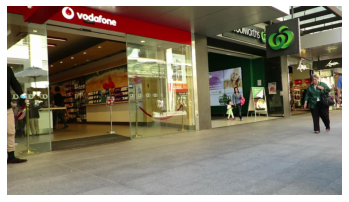

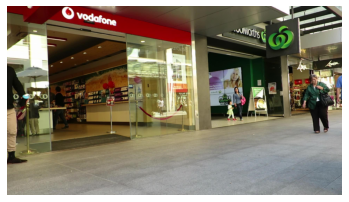

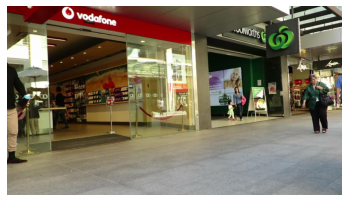

In [4]:
motdata = join(MOT_PATH,'img1/')
sys.path.append(motdata)


import matplotlib.pylab as plt
import cv2

list_motdata = os.listdir(motdata)  
list_motdata.sort()

# Printing frames before detection
for i in range(3):
  img_ex_path = motdata + list_motdata[i]
  img_ex_origin = cv2.imread(img_ex_path)
  img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

  plt.imshow(img_ex)
  plt.axis('off')
  plt.show()

In [ ]:
# Download the pretrained Faster R-CNN model from torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

In [6]:
# Class names in MS COCO

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]



Here you are expected to write the code for selecting objects with higher softmax scores wrt the given a threshold value. 

*You can assume that the outputs (detections) are already sorted in a decreasing order wrt softmax scores.  Each  output  box  is  associated with  a  category  label,  a  softmax  score  in [0,1], and BB coordinates.*


In [7]:
# inference with PyTorch

def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  
  
  #INFERENCE

  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  
  ##
  # YOUR CODE HERE
  ##

  
  return pred_boxes, pred_class,pred_score

In [8]:
# Defining a api function for object detection

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3, viz=True):
 
  boxes, pred_cls, pred_score = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img0 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class

  if viz == True:
    
    fig, ax = plt.subplots(1, 2,figsize=(25,500))
    ax[0].imshow(img0) #col=0
    ax[1].imshow(img) #col=1
    plt.show()
  return (boxes,pred_cls,pred_score)

Recommended threshold is 0.8, but you may want to experiment with different th values. If you failed the previous question, you will see a high number of detections in your outputs, and will take a long time to finish

<ipython-input-8-9246395ce619>:12: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
<ipython-input-8-9246395ce619>:13: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class


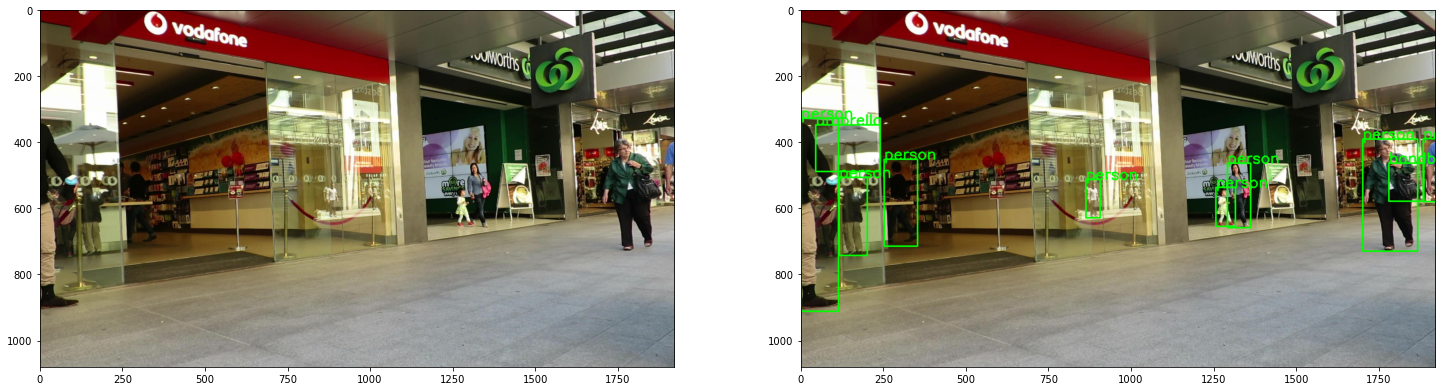

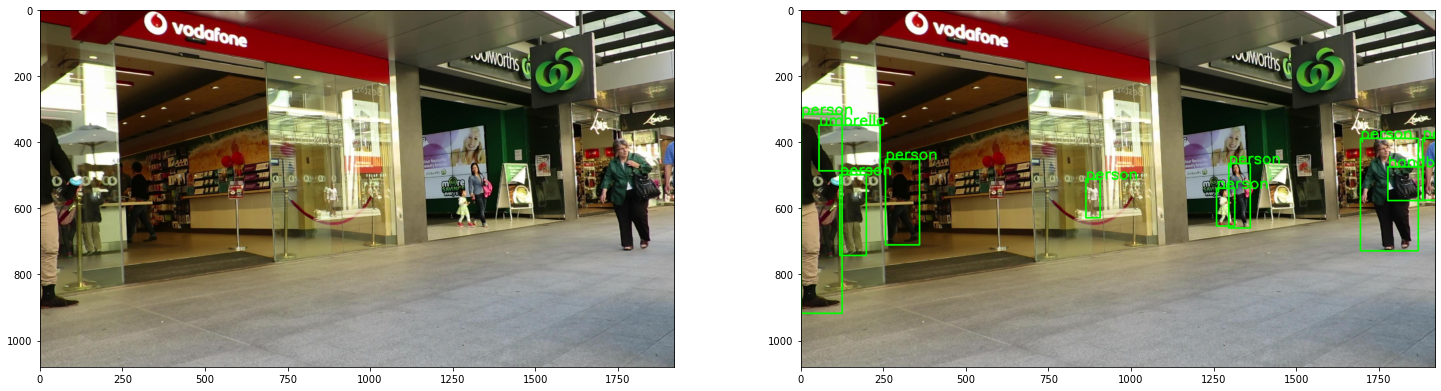

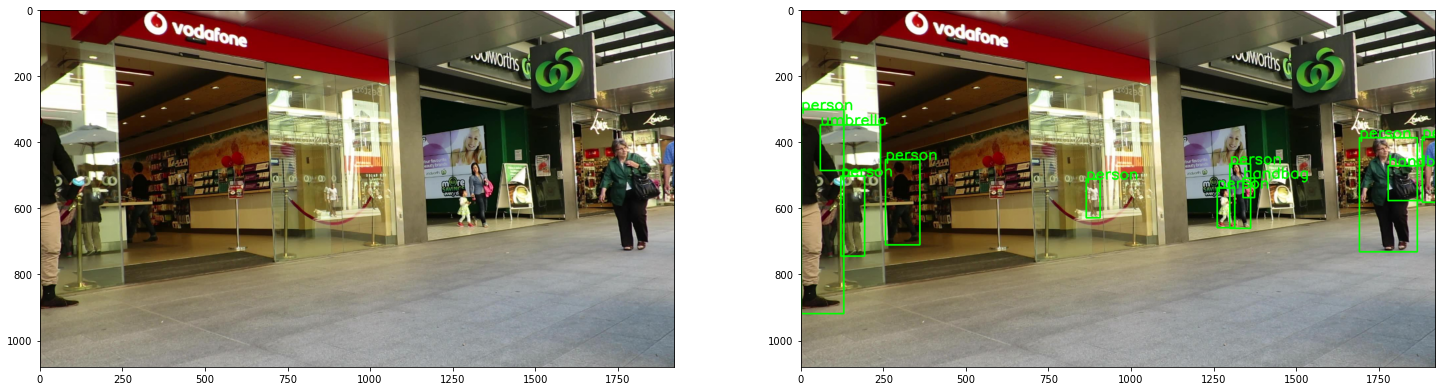

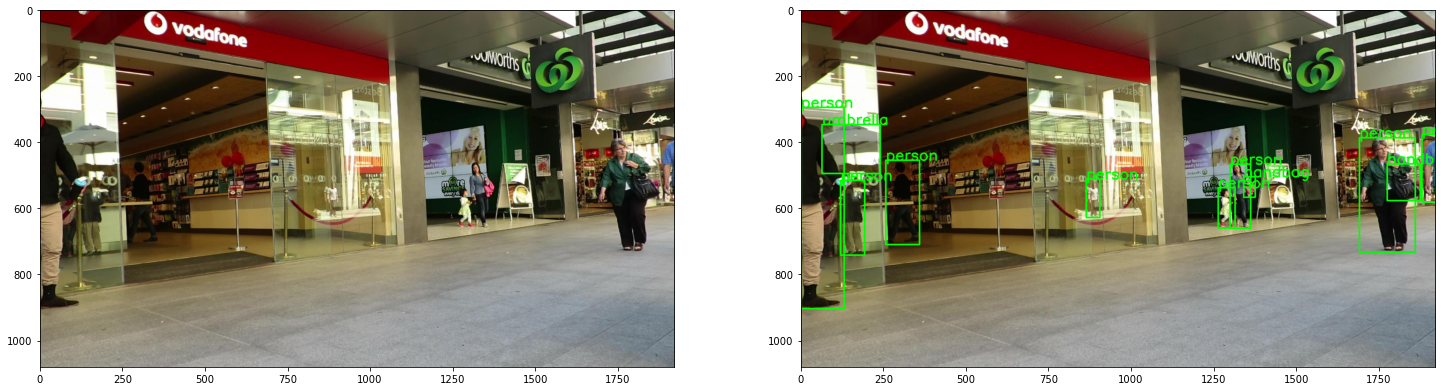

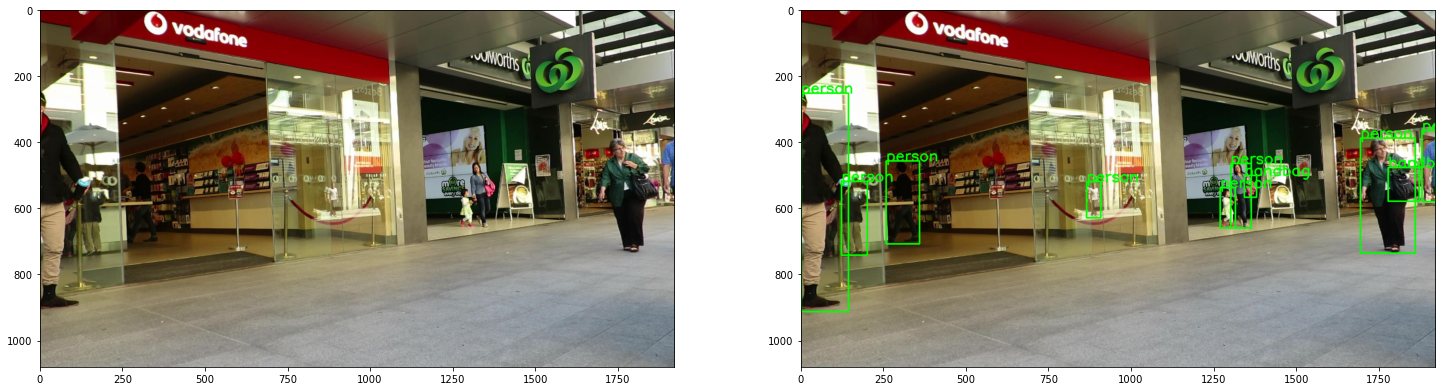

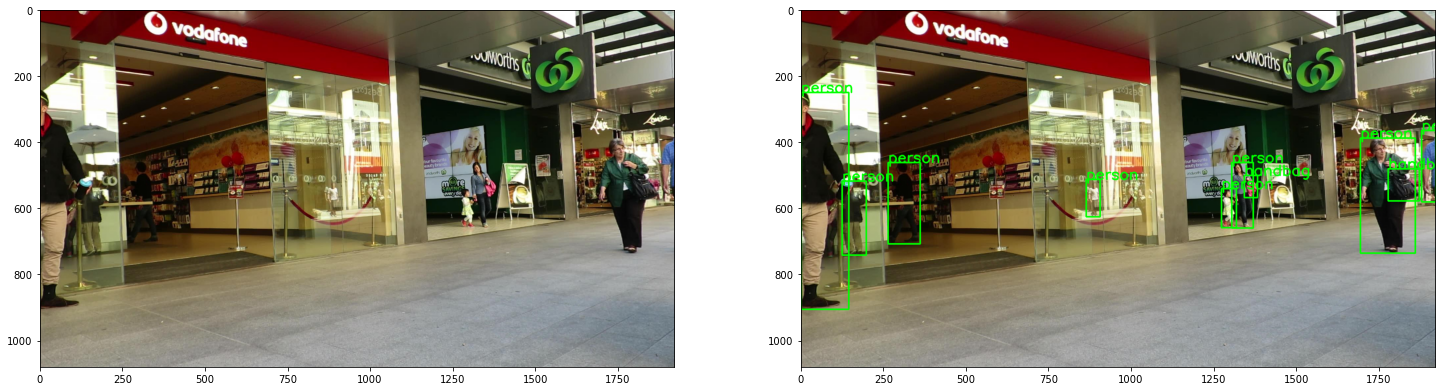

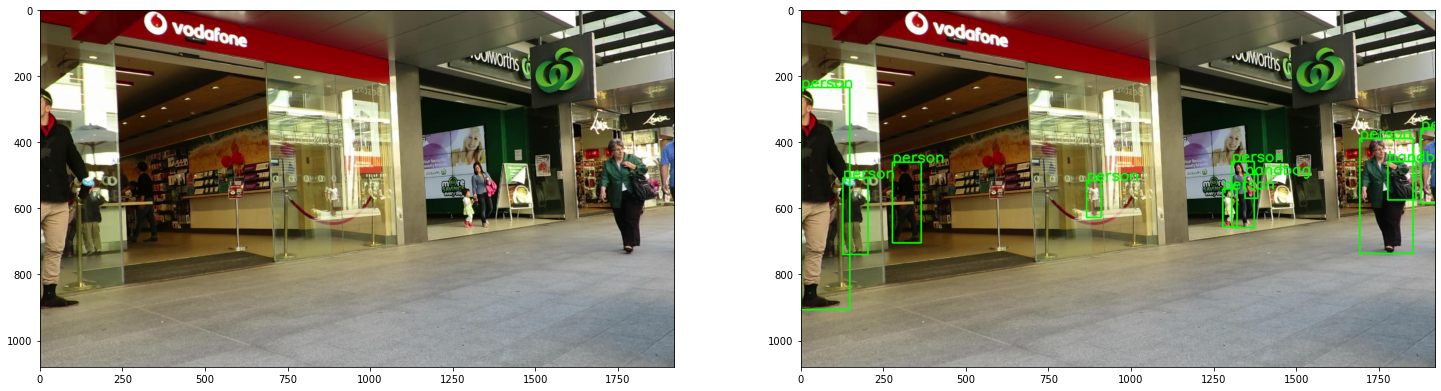

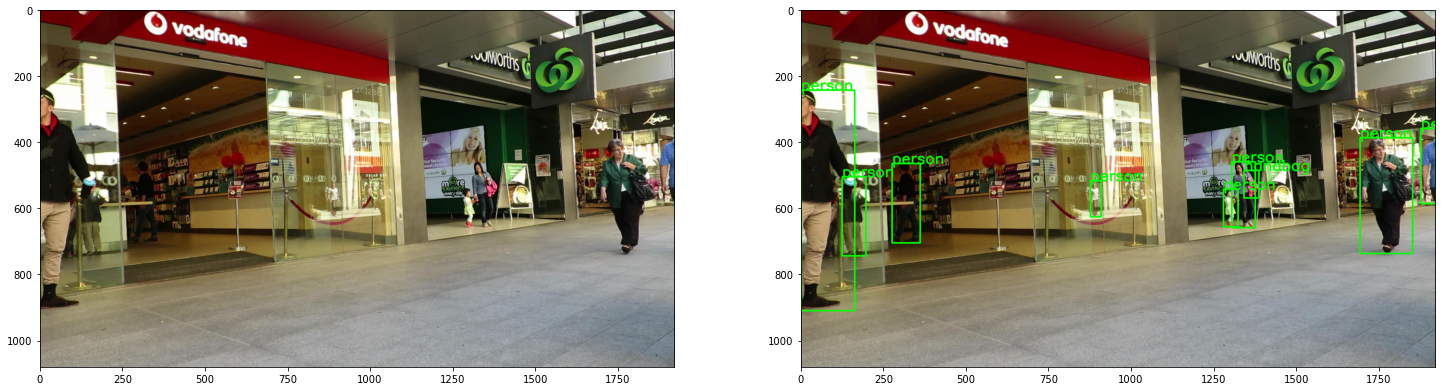

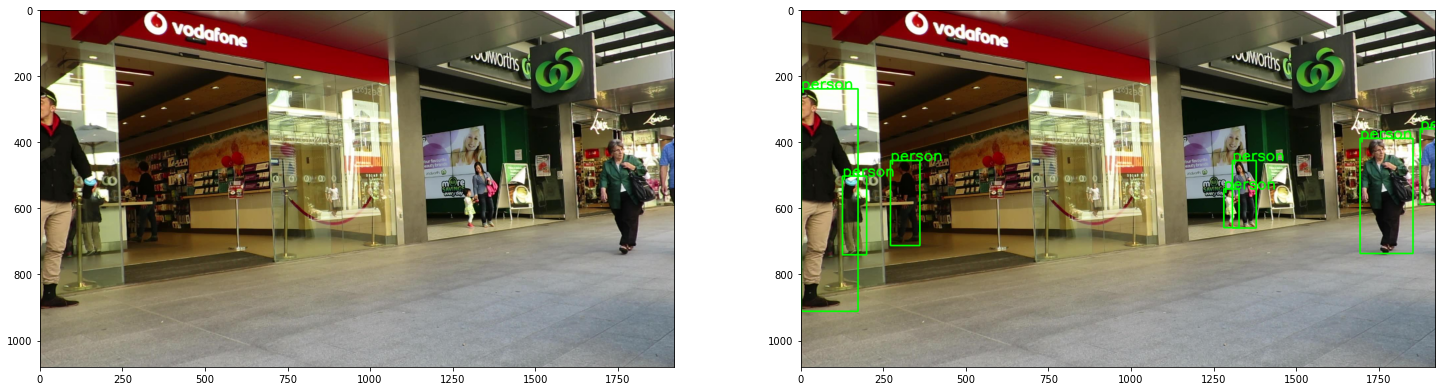

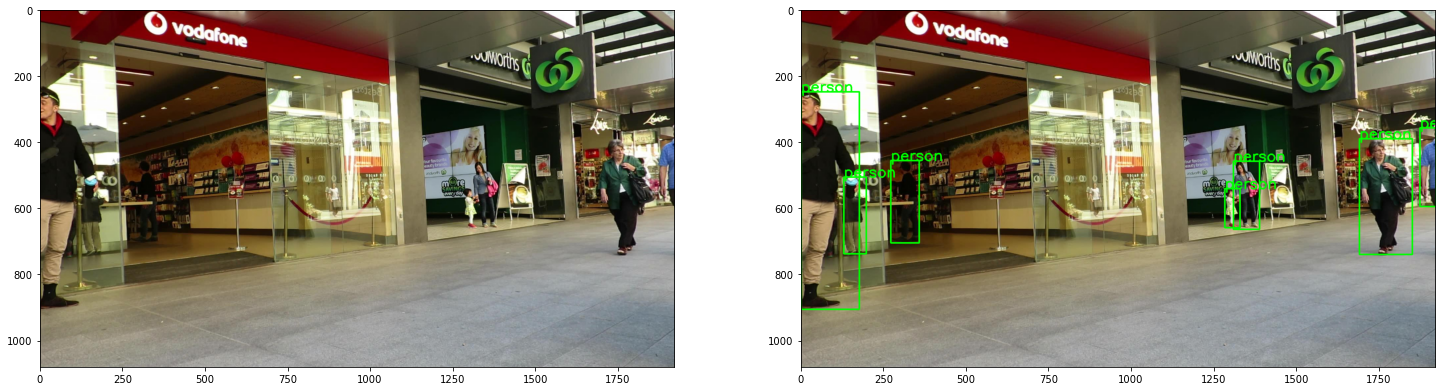

In [9]:
th=0.8
store=dict()

for i in range(10):
  img_ex_path = motdata + list_motdata[i]
  img_ex_origin = cv2.imread(img_ex_path)

  bb, cls, score = object_detection_api(img_ex_path, threshold=th, viz = True)
  img_name = img_ex_path.split('/')[-1]  
  store[img_name]=[{'bbox':list(sum(bb[i], ())), 'labels':cls[i], 'scores':score[i]} for i in range(len(cls))]
  

In [11]:
# In store (a dictionary), we store bbox (x1,y1,x2,y2), labels, score (softmax) for each image
store['000001.jpg'][0]

{'bbox': [1698.189, 390.92215, 1864.7689, 729.7769],
 'labels': 'person',
 'scores': 0.99901986}

# Question 3


## Part 1 
Given a distance matrix between previous detections (N) and new detections (N), how many 1-1 matching is possible?

ANSWER

## Part 2

Please compare your answer with the complexity of hungarian algorithm.

ANSWER

## Part 3
You are supposed to implement an algorithm for associating the previous detections with the current ones. Using the BBs from first and second image, create an IoU matrix using BB_1 as tracks and BB_2 new detections.

In [ ]:
# # You can check 'store' variable
store.values()

In [10]:
#select BBs from first two frames
bb1 = [i['bbox'] for i in list(store.values())[0]]
bb2 = [i['bbox'] for i in list(store.values())[1]]

In [11]:
# code taken from: https://gist.github.com/meyerjo/dd3533edc97c81258898f60d8978eddc

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

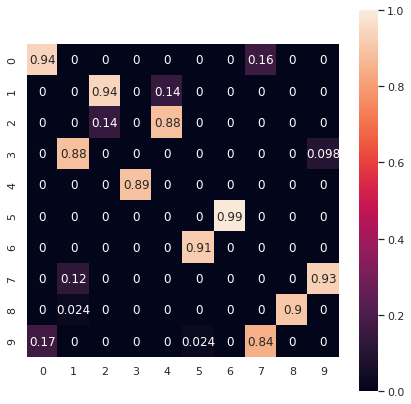

In [12]:
# calculate  IoU for each combination to fill the matrix M
# horizontal new detections
# vertical past detections as tracks
# Visualize the matrix

M = np.zeros((len(bb1), len(bb2)))

##
# YOUR CODE HERE
##


import seaborn as sns; sns.set_theme()

f, ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(M, annot=True, vmin=0,vmax=1,square=True)


## Part 4 

Write a minimal association function for matching past tracks with new detections given the IoU matrix. We do not have unmatched detections (IoU threshold) in this example. And, it is okay to do matching in the given order (first track is matched, second tract is matched, ..., Nth track is matched.) 

You can use `%%time` to see your code's execution time.

In [13]:
#you are now supposed to find the corresponded tracks (y axis) matches for each new track (x axis)

def minimal_association(M):
  ##
  #YOUR CODE HERE
  ##
  return(inds)

In [14]:
%%time
minimal_association(M)

CPU times: user 241 µs, sys: 22 µs, total: 263 µs
Wall time: 194 µs


array([0., 2., 4., 1., 3., 6., 5., 9., 8., 7.])

Now install munkres library to see the performance of Munkres (Hungarian algorithm). Munkres optimizes for minimum cost, so you need to adapt your Matrix M of IoU accordingly.

In [17]:
!pip install munkres

In [15]:
from munkres import Munkres

m = Munkres()
##
# YOUR CODE HERE
M_n = None
##

In [16]:
%%time
indexes = m.compute(M_n)

CPU times: user 141 µs, sys: 13 µs, total: 154 µs
Wall time: 156 µs


In [17]:
indexes

[(0, 0),
 (1, 2),
 (2, 4),
 (3, 1),
 (4, 3),
 (5, 6),
 (6, 5),
 (7, 9),
 (8, 8),
 (9, 7)]

## Part 5

Use Simple Online and Realtime Tracking (SORT) Algorithm

Source: [SORT Github](https://github.com/abewley/sort/)

"SORT is an online tracking algorithm which only uses past and current frames. Please note that accuracy of the SORT hugely depends on the detections. It is designed for online tracking applications where only past and current frames are available and the method produces object identities on the fly. While this minimalistic tracker doesn't handle occlusion or re-entering objects its purpose is to serve as a baseline and testbed for the development of future trackers.

SORT algorithm basically uses

* Kalman Filter as the estimation model.
* Hungarian Algorithm for data association a.k.a. matching estimations with ongoing tracks.
* IOU thresholding the unmatched detections for creating a new track identity. 
* T_lost counting for deleting the identity. (When an object is not matched for t frames it is deleted.)"

In [18]:
#SORT 
# Git clone: SORT Algorithm (to the same path that you defined at the beginning.)

!git clone https://github.com/abewley/sort.git
sort = 'sort/'
sys.path.append(sort)

fatal: destination path 'sort' already exists and is not an empty directory.


In [19]:
cd "{sort}"

/home/ssafadoust20/Courses/CVAD/Assignments/MOT/sort


In [ ]:
pip install -r requirements.txt

In [20]:
import skimage
print(skimage.__version__)

0.17.2


In [21]:
img_path = os.path.join('..', motdata)    # img root path
# Making new directory for saving results
save_path = 'save_your_results/'
!mkdir "{save_path}"
#results in content/sort/save

mkdir: cannot create directory ‘save_your_results/’: File exists


In [22]:
#if it throws an error, run the cell again
import matplotlib
matplotlib.use('TKAgg')


In [23]:
import json
import collections
from pprint import pprint
from sort import *
np.set_printoptions(suppress=True)

mot_tracker = Sort()      # Tracker using SORT Algorithm

In [24]:
#here we use our detections by Faster R CNN for tracking
#inputing them to SORT

store2 = collections.OrderedDict(sorted(store.items()))
bbs_ids=dict()
for key in store2.keys():   
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    overlay = det_img.copy()
    det_result = store2[key] 
    
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 'person': # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    bbs_ids[int(key.split('.')[0])]=np.float32(track_bbs_ids)

    mot_imgid = key.replace('.jpg','')
    newname = save_path + mot_imgid + '_mot.jpg'
    print(mot_imgid)
    
    for j in range(track_bbs_ids.shape[0]):  
        ##
        #YOUR CODE HERE
        x = None
        y = None
        x2 = None
        y2 = None
        track_label = None
        ##
        cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
        cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
            
    cv2.imwrite(newname,det_img)
    
    if is_colab:
        cv2_imshow(cv2.resize(det_img, (960, 540)))
    else:
        cv2.imshow('img', cv2.resize(det_img, (960, 540)))
    cv2.waitKey(100)
    
if not is_colab:
    cv2.destroyAllWindows()        
    

000001
000002
000003
000004
000005
000006
000007
000008
000009
000010


In [25]:
# edit bbs_ids with the shape 
# {image name: object id, x1, y1, w, h}
# remember current format is x1,y1,x2,y2

sort_id_bbs =bbs_ids.copy()
for k in bbs_ids.keys():
  sort_id_bbs[k]= sort_id_bbs[k][:, [4, 0, 1, 2, 3]]
  sort_id_bbs[k][:,3:5]=sort_id_bbs[k][:,3:5]-sort_id_bbs[k][:,1:3]

In [26]:
# #check new format if you want
sort_id_bbs[1]

array([[   8.       ,  115.42345  ,  506.15353  ,   85.46971  ,
         236.5604   ],
       [   7.       , 1881.9286   ,  389.66904  ,   38.07141  ,
         190.0701   ],
       [   6.       ,  861.0734   ,  512.28284  ,   43.347412 ,
         116.213684 ],
       [   5.       ,  251.4367   ,  451.7073   ,  101.170654 ,
         262.7429   ],
       [   4.       ,   -0.0000014,  327.20285  ,  113.80242  ,
         584.2003   ],
       [   3.       , 1254.3234   ,  536.06964  ,   59.539307 ,
         118.549805 ],
       [   2.       , 1289.7858   ,  463.80878  ,   69.29785  ,
         194.97339  ],
       [   1.       , 1698.189    ,  390.92215  ,  166.57996  ,
         338.85477  ]], dtype=float32)

Now, we first visualize the gt BBs and tracks. MOT17 dataset is described as follows. (MOT16 and 17 have same format)

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1uqHXqacyNs2IK8RGoUAKNzQc_UqQezDL" alt="Table5" width="650"/>
<img src="https://drive.google.com/uc?export=view&id=1sAU6xOKlgrJcvliALycaMjM2MQwvgDdk" alt="Table6" width="330"/>
</p>

<center>
Image source: <a href="https://arxiv.org/pdf/1603.00831.pdf">MOT16: A Benchmark for Multi-Object Tracking</a>
</center>

In [27]:
gt_s = np.intc(np.loadtxt(join('..', MOT_PATH+'/gt/gt.txt'),dtype=np.float64, delimiter=','))


In [28]:
#this function is used for reading gt id and bbs from MOT17-09
def bbx(X, imgN=1):

  mask = (X[:, 0] ==imgN ) & (X[:, -3] ==1) #class 7 (-3) which flags the considered ==1
  X = X[mask] #frm_id,seq_id,xmin,ymin,w,h,confidence,class,visibility
  bbs = X[:, 1:6] #seq_id,xmin,ymin,w,h
  
  return np.intc(bbs)


In [29]:
#shows gt tracks in image 00002
bbx(gt_s,imgN = 2)

array([[   1,  262,  449,  102,  263],
       [  19, 1685,  386,  170,  347],
       [  20, 1883,  326,  157,  406],
       [  21, 1256,  534,   62,  127],
       [  22, 1293,  458,   71,  203],
       [  23, -340,  234,  473,  695]], dtype=int32)

In [89]:
def print_gt(gt_s, img_N,img_path):
  img_path = img_path+str(img_N).zfill(6)+'.jpg'  
  img = cv2.imread(img_path) # Read image with cv2
  K = bbx(gt_s,img_N)


  for i in range(K.shape[0]):
    ##
    # YOUR CODE HERE
    x = None
    y = None
    x2 = None
    y2 = None
    ## 
    cv2.rectangle(img, (x, y), (x2, y2), color=(0, 255, 0), thickness=10) # Draw Rectangle with the coordinates
    cv2.putText(img, str(K[i][0]), (x, y),  cv2.FONT_HERSHEY_SIMPLEX, 1, color=(0,255,0),thickness=2) # Write the prediction clas


  cv2.imwrite('save_your_results/{:06d}_gt.jpg'.format(img_N), img)

In [90]:
p = join('..',MOT_PATH,'img1/')
for i in range(10):    
  print_gt(gt_s,i+1,p)


## Part 6

o_k denote from ground truths, h_k denote tracking results. You can see that mismatches can occur when there are occlusions.

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1KHYeG0-PZz3a9Eah4p4sGEWuPTwtIs-a" alt="Fast R-CNN" width="900"/>
</p>

<center>
Tracking visualization.
</center>

<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1O5jFYCm3H0vDZOMq-yLQ8LFmSENJxHjU" alt="Fast R-CNN" width="350"/>
</p>

<center>
MOTA 
</center>
Source: <a href="https://www.researchgate.net/publication/26523191_Evaluating_multiple_object_tracking_performance_The_CLEAR_MOT_metrics">Bernardin, Keni, and Rainer Stiefelhagen. "Evaluating multiple object tracking performance: the CLEAR MOT metrics." EURASIP Journal on Image and Video Processing 2008.1 (2008): 1-10</a>


In [ ]:
!pip install motmetrics

In [41]:
import motmetrics as mm
# List all default metrics
mh = mm.metrics.create()
print(mh.list_metrics_markdown())

Name|Description
:---|:---
num_frames|Total number of frames.
obj_frequencies|Total number of occurrences of individual objects over all frames.
pred_frequencies|Total number of occurrences of individual predictions over all frames.
num_matches|Total number matches.
num_switches|Total number of track switches.
num_transfer|Total number of track transfer.
num_ascend|Total number of track ascend.
num_migrate|Total number of track migrate.
num_false_positives|Total number of false positives (false-alarms).
num_misses|Total number of misses.
num_detections|Total number of detected objects including matches and switches.
num_objects|Total number of unique object appearances over all frames.
num_predictions|Total number of unique prediction appearances over all frames.
num_unique_objects|Total number of unique object ids encountered.
track_ratios|Ratio of assigned to total appearance count per unique object id.
mostly_tracked|Number of objects tracked for at least 80 percent of lifespan.
par

In [42]:
#example from https://github.com/cheind/py-motmetrics
#iou_matrix gives 1-IoU, since it solves the minimal cost association
a = np.array([
    [0, 0, 1, 2],    # Format X, Y, Width, Height
    [0, 0, 0.8, 1.5],
])

b = np.array([
    [0, 0, 1, 2],
    [0, 0, 1, 1],
    [0.1, 0.2, 2, 2],
])
mm.distances.iou_matrix(a, b)

array([[0.        , 0.5       , 0.63013699],
       [0.4       , 0.42857143, 0.78787879]])

In [43]:
#printing sequence ids in image 00001
bbx(gt_s,imgN=1)[:,0]

array([ 1, 19, 20, 21, 22, 23], dtype=int32)

In [44]:
#remember formats
#id x y width height
print(bbx(gt_s,imgN=1)[:,0:])
print(sort_id_bbs[1])

[[   1  260  450  102  262]
 [  19 1686  387  171  345]
 [  20 1886  327  156  404]
 [  21 1253  533   63  129]
 [  22 1292  459   70  202]
 [  23 -348  235  477  695]]
[[   8.         115.42345    506.15353     85.46971    236.5604   ]
 [   7.        1881.9286     389.66904     38.07141    190.0701   ]
 [   6.         861.0734     512.28284     43.347412   116.213684 ]
 [   5.         251.4367     451.7073     101.170654   262.7429   ]
 [   4.          -0.0000014  327.20285    113.80242    584.2003   ]
 [   3.        1254.3234     536.06964     59.539307   118.549805 ]
 [   2.        1289.7858     463.80878     69.29785    194.97339  ]
 [   1.        1698.189      390.92215    166.57996    338.85477  ]]


In [45]:
#calculate IoU given bbx and sort_id_bbs
#remember 
#bbx(gt_s,imgN=1) #seq_id,xmin,ymin,w,h
#sort_id_bbs[1] #seq_id,xmin,ymin,w,h

N=1 #given image number
##
# YOUR CODE HERE
##
print(ans)


[[0.         0.         0.         0.82549032 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.87321155]
 [0.         0.10129468 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.86850907
  0.17977707 0.        ]
 [0.         0.         0.         0.         0.         0.1392958
  0.8975964  0.        ]
 [0.00921513 0.         0.         0.         0.2005442  0.
  0.         0.        ]]


## Part 7
Create an accumulator that will be updated during each frame. and calculate MOTA

In [60]:
# Create an accumulator that will be updated during each frame
acc = mm.MOTAccumulator(auto_id=True)

# Call update once for per frame. For now, assume distances between
# frame objects / hypotheses are given.

def acc_update(acc,N):

  gt_id_bbx = bbx(gt_s,imgN=N)
  gt_id, gt_bbx = gt_id_bbx[:,0:1],gt_id_bbx[:,1:5]

  pred_id_bbx = sort_id_bbs[N]
  sort_id, sort_bbx = pred_id_bbx[:,0:1],pred_id_bbx[:,1:]
  ans = 1-mm.distances.iou_matrix(a, b)
    
  ##  
  # YOUR CODE HERE:
  # Call acc.update
  ##

  return acc



In [61]:
#empty
print(acc.mot_events)

Empty DataFrame
Columns: [Type, OId, HId, D]
Index: []


In [62]:
#for first 1...T images compute MOTA
acc = mm.MOTAccumulator(auto_id=True)
for i in range(10):
  acc = acc_update(acc,i+1)

In [63]:
print(acc.mot_events)

                Type   OId  HId         D
FrameId Event                            
0       49     MATCH   1.0  5.0  0.174510
        50     MATCH  19.0  1.0  0.126788
        51     MATCH  20.0  7.0  0.898705
        52     MATCH  21.0  3.0  0.131491
        53     MATCH  22.0  2.0  0.102404
...              ...   ...  ...       ...
9       52     MATCH  19.0  1.0  0.136065
        53     MATCH  20.0  7.0  0.831522
        54     MATCH  21.0  3.0  0.270961
        55     MATCH  22.0  2.0  0.131522
        56     MATCH  23.0  4.0  0.620301

[78 rows x 4 columns]


In [88]:
mh = mm.metrics.create()
##
# YOUR CODE HERE
# CALCULATE MOTA
summary = None
##
print(summary)


     num_frames      mota      motp
acc          10  0.741935  0.400939
